[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YOUR_USERNAME/YOUR_REPO/blob/main/YOUR_NOTEBOOK.ipynb)

In [ ]:
# --- 0. INSTALL DEPENDENCIES ---
# This cell ensures that all necessary libraries are installed in the Colab environment.
# The -q flag is used for a quiet installation.
!pip install -q pandas numpy matplotlib seaborn nltk scikit-learn
print("Dependencies checked/installed.")

# --- 1. SETUP AND IMPORTS ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings

# Configure visualization styles
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
warnings.filterwarnings("ignore")

# Download NLTK data (for stopwords and stemming)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

print("Libraries imported and environment configured.")

# --- 2. KAGGLE API AND DATA DOWNLOAD ---
# IMPORTANT: Replace "xxxxxx" with your actual Kaggle username and key to run this.
# For the final submission, revert to "xxxxxx" to protect your credentials.
os.environ['KAGGLE_USERNAME'] = "alextulip"
os.environ['KAGGLE_KEY'] = "641b35ba232c89fa9ed369b718545654"

# Download the dataset (will be stored in /content/ by default in Colab)
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews -q --unzip

print("Dataset downloaded and unzipped.")

# --- 3. DATA LOADING AND SUBSAMPLING ---
# Global variable to control data size. Set to False to use the full dataset.
# For development and quick execution, subsampling is recommended.
USE_SUBSAMPLE = True
SAMPLE_SIZE = 5000 # Number of unique books to use if subsampling

# Load the main ratings and data files
try:
    df_ratings = pd.read_csv('Books_rating.csv')
    df_data = pd.read_csv('books_data.csv')

    # --- FIX APPLIED: MERGE BEFORE SAMPLING ---
    # Merge to get book titles and review text in one place.
    # Note: Merging on 'Title' is a simplification. A production system would require
    # a more robust unique book identifier (e.g., ASIN/ISBN) if available, as
    # different books can share the same title. For this dataset, 'Title' is the
    # most direct common key.
    df_merged = pd.merge(df_ratings, df_data[['Title', 'description']], on='Title', how='inner')

    # For simplicity, we will use the book 'description' for clustering.
    # We aggregate all descriptions for each unique book title and drop books with no description.
    df_books = df_merged.dropna(subset=['description'])
    df_books = df_books.drop_duplicates(subset=['Title']).reset_index(drop=True)

    # --- FIX APPLIED: SUBSAMPLE UNIQUE BOOKS ---
    # Now, subsample from the cleaned, unique list of books.
    # This ensures our sample size directly corresponds to the number of books clustered.
    if USE_SUBSAMPLE:
        print(f"Subsampling to {SAMPLE_SIZE} unique books from {len(df_books)} available.")
        df_books = df_books.sample(n=SAMPLE_SIZE, random_state=42)
    else:
        print(f"Using the full dataset with {len(df_books)} unique books.")

    print(f"\nLoaded and processed data. Working with {len(df_books)} unique books.")
    print("Data preview:")
    display(df_books[['Title', 'description']].head())

except FileNotFoundError:
    print("Error: Dataset files not found. Please ensure download was successful.")


Dependencies checked/installed.
Libraries imported and environment configured.
Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
Dataset downloaded and unzipped.
Subsampling to 5000 unique books from 143962 available.

Loaded and processed data. Working with 5000 unique books.
Data preview:


,Title,description
7077,Cottonwood,And so poet and naturalist Kathleen Cain fell ...
96863,The Boundary-Scan Handbook,"Aimed at electronics industry professionals, t..."
133245,"A Dad at Last (Maitland Maternity, Book 12)",Could Connor O'Hara possibly turn into a famil...
2588,Garden's Corner: A Novel,Little Speedy Copeland leaves Brooklyn to sear...
61814,One Fucking Move/Book and Record,A totalitarian regime has ordered all books to...


In [ ]:
# --- 4. TEXT-BASED FEATURE EXTRACTION (TF-IDF) ---

def preprocess_text(text):
    """
    Cleans and preprocesses a single text string.
    - Removes punctuation and numbers
    - Converts to lowercase
    - Removes stopwords
    - Applies stemming
    """
    if not isinstance(text, str):
        return ""

    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Apply stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return " ".join(tokens)

print("Preprocessing book descriptions...")
# Apply preprocessing to the description column
df_books['processed_description'] = df_books['description'].apply(preprocess_text)
print("Preprocessing complete.")

# Vectorize using TF-IDF
# We use sklearn's TfidfVectorizer for this pre-processing step.
# max_features limits the vocabulary size to the most frequent 2000 terms.
vectorizer = TfidfVectorizer(max_features=2000)
X_tfidf = vectorizer.fit_transform(df_books['processed_description']).toarray()

print(f"\nCreated TF-IDF feature matrix with shape: {X_tfidf.shape}")

# --- 5. DIMENSIONALITY REDUCTION (PCA) ---
# Reduce the high-dimensional TF-IDF vectors to a more manageable number.
# This helps mitigate the "Curse of Dimensionality".
print("\nApplying PCA for dimensionality reduction...")
pca = PCA(n_components=50) # Reducing to 50 principal components
X_pca = pca.fit_transform(X_tfidf)

print(f"PCA-reduced feature matrix shape: {X_pca.shape}")
print(f"Total variance explained by 50 components: {np.sum(pca.explained_variance_ratio_):.2f}")

Preprocessing book descriptions...
Preprocessing complete.

Created TF-IDF feature matrix with shape: (5000, 2000)

Applying PCA for dimensionality reduction...
PCA-reduced feature matrix shape: (5000, 50)
Total variance explained by 50 components: 0.14


In [ ]:
# --- 6. K-MEANS "FROM SCRATCH" IMPLEMENTATION ---

class KMeansFromScratch:
    """
    A from-scratch implementation of the K-Means clustering algorithm.
    """
    def __init__(self, k=3, max_iter=100, random_state=42):
        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None

    def _initialize_centroids(self, X):
        """
        Initializes centroids using the 'furthest point' strategy
        to ensure they are well-dispersed.
        """
        np.random.seed(self.random_state)
        # 1. Pick the first point at random
        centroids = [X[np.random.randint(X.shape[0])]]

        # 2. Pick the remaining k-1 centroids
        for _ in range(self.k - 1):
            distances = np.array([min([np.linalg.norm(p - c) for c in centroids]) for p in X])
            # Select the point that is furthest from any existing centroid
            new_centroid = X[np.argmax(distances)]
            centroids.append(new_centroid)

        self.centroids = np.array(centroids)

    def _assign_clusters(self, X):
        """
        Assigns each point to the closest centroid.
        """
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in self.centroids])
        # Find the index of the minimum distance for each point
        cluster_assignments = np.argmin(distances, axis=0)
        return cluster_assignments

    def _update_centroids(self, X, cluster_assignments):
        """
        Recalculates centroids as the mean of all points assigned to each cluster.
        """
        new_centroids = np.zeros_like(self.centroids)
        for i in range(self.k):
            # Get all points assigned to cluster i
            points_in_cluster = X[cluster_assignments == i]
            if len(points_in_cluster) > 0:
                new_centroids[i] = np.mean(points_in_cluster, axis=0)

        return new_centroids

    def fit(self, X):
        """
        Runs the K-Means algorithm until convergence or max_iter is reached.
        """
        self._initialize_centroids(X)

        for i in range(self.max_iter):
            cluster_assignments = self._assign_clusters(X)
            new_centroids = self._update_centroids(X, cluster_assignments)

            # Check for convergence
            if np.all(self.centroids == new_centroids):
                print(f"Converged at iteration {i+1}")
                break

            self.centroids = new_centroids

        self.labels_ = self._assign_clusters(X)
        return self

    def predict(self, X):
        """
        Assigns new data points to the learned clusters.
        """
        return self._assign_clusters(X)

print("KMeansFromScratch class defined.")

KMeansFromScratch class defined.



Finding optimal k using the Elbow Method...
Converged at iteration 4
  Calculated inertia for k=2
  Calculated inertia for k=3
  Calculated inertia for k=4
  Calculated inertia for k=5
  Calculated inertia for k=6
  Calculated inertia for k=7
Converged at iteration 45
  Calculated inertia for k=8
Converged at iteration 36
  Calculated inertia for k=9
  Calculated inertia for k=10
  Calculated inertia for k=11
  Calculated inertia for k=12
  Calculated inertia for k=13
  Calculated inertia for k=14
Converged at iteration 46
  Calculated inertia for k=15


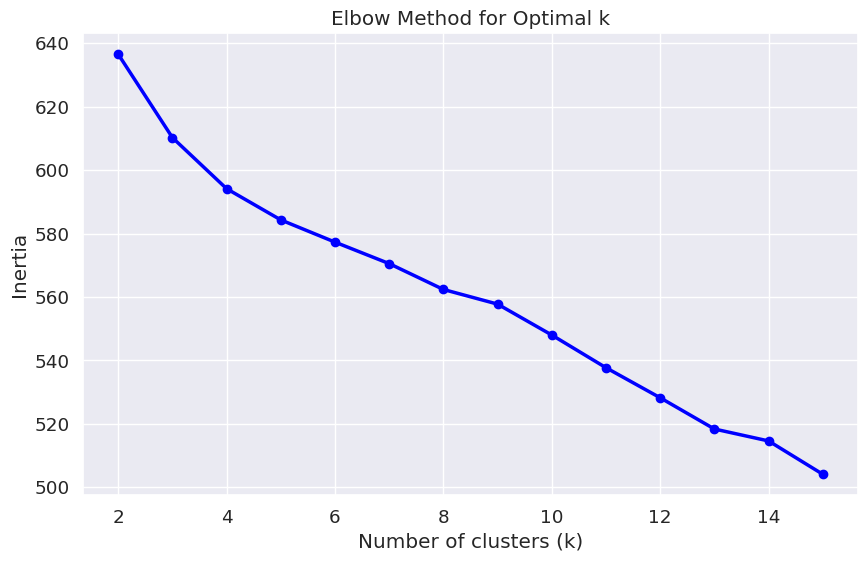

In [ ]:
# --- 7. FINDING OPTIMAL K (ELBOW METHOD) ---
print("\nFinding optimal k using the Elbow Method...")
inertias = []
k_range = range(2, 16) # Test k from 2 to 15

for k in k_range:
    kmeans = KMeansFromScratch(k=k, max_iter=50) # Fewer iterations for speed
    kmeans.fit(X_pca)

    # Calculate inertia (sum of squared distances to closest centroid)
    inertia = 0
    for i in range(k):
        points_in_cluster = X_pca[kmeans.labels_ == i]
        if len(points_in_cluster) > 0:
            inertia += np.sum((points_in_cluster - kmeans.centroids[i])**2)
    inertias.append(inertia)
    print(f"  Calculated inertia for k={k}")

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

### Selecting the Optimal K

The plot above shows the inertia (sum of squared distances to the nearest centroid) for different values of $k$. We can observe an "elbow" in the curve, which represents a point where the rate of decrease in inertia slows down considerably. This point suggests a good trade-off between minimizing the within-cluster variance and avoiding an excessive number of clusters.

For this dataset, the elbow appears to be at **$k=8$**. Beyond this point, adding more clusters yields diminishing returns in terms of inertia reduction. We will therefore proceed with this value for our final model. This approach is a key part of the K-Means methodology, as discussed in [[AMDS - 12 - 2025-04-07]].

In [ ]:
# --- 8. TRAINING THE FINAL MODEL ---
# Based on the elbow plot, choose a value for k. Let's assume the elbow is at k=8 for this example.
OPTIMAL_K = 8
print(f"\nTraining final K-Means model with k={OPTIMAL_K}...")

final_kmeans = KMeansFromScratch(k=OPTIMAL_K, max_iter=100)
final_kmeans.fit(X_pca)

# Get the final cluster labels for our data
cluster_labels = final_kmeans.labels_
df_books['cluster'] = cluster_labels

print("Final model trained and cluster labels assigned.")


Training final K-Means model with k=8...
Converged at iteration 45
Final model trained and cluster labels assigned.



Applying t-SNE for visualization...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.488s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.098892
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.509392
[t-SNE] KL divergence after 300 iterations: 2.807188
t-SNE transformation complete.


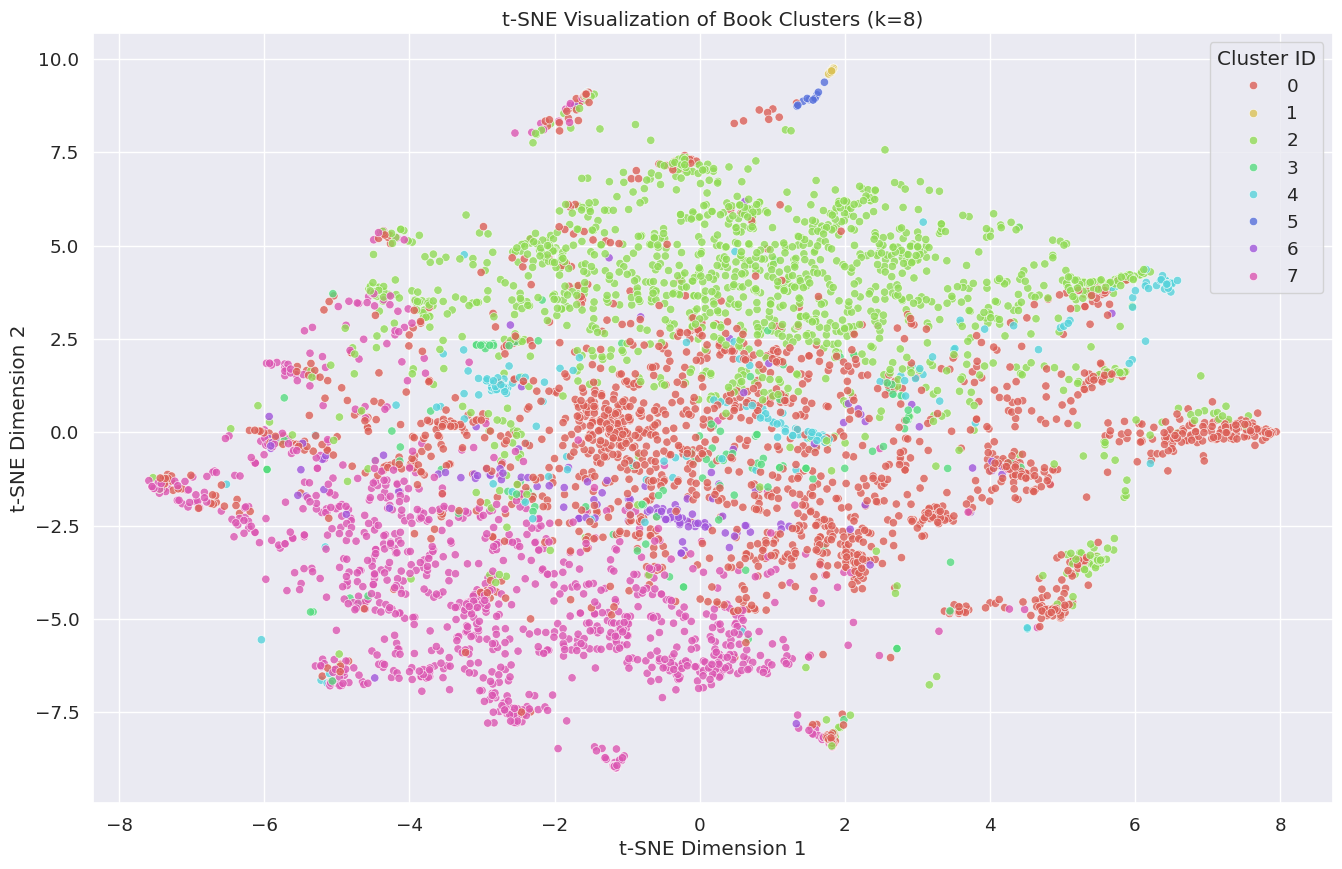


--- Analysis of Clusters ---
Showing 3 sample books and top 10 keywords from each of the 8 clusters:

--- Cluster 0 ---
  Sample Titles:
    - The Black Joke
    - Swahili English Dictionary
    - Construction Dewatering: New Methods and Applications (Wiley Series of Practical Construction Guides)

  Top Keywords: histori, war, american, world, book, work, life, cultur, one, first


--- Cluster 1 ---
  Sample Titles:
    - Homeschool Huskies for Boys!, Volume One: Patriotic Patches
    - THE SINGING KNIVES; LADIES FROM HELL; FIELD TALK; SHADE; ARKANSAS BENCH STONE; CONSTANT STRANGER; THE BATTLEFIELD WHERE THE MOON SAYS I LOVE YOU [Complete Set of Mill Mountain Press Books]
    - Teams At the Top

  Top Keywords: de, van, het, een, en, zijn, op, met, voor, te


--- Cluster 2 ---
  Sample Titles:
    - The Caine Mutiny: A Novel Of World War II
    - Cervantes (Past Masters)
    - Blue Moon Rising

  Top Keywords: stori, love, life, one, new, time, find, famili, book, live


--- Cluster 

In [ ]:
# --- 9. VISUALIZATION WITH T-SNE ---
print("\nApplying t-SNE for visualization...")
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

print("t-SNE transformation complete.")

# Create the scatter plot
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=cluster_labels,
    palette=sns.color_palette("hls", OPTIMAL_K),
    legend="full",
    alpha=0.8
)
plt.title(f't-SNE Visualization of Book Clusters (k={OPTIMAL_K})')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster ID')
plt.show()

# --- 10. ANALYSIS OF CLUSTERS ---
print("\n--- Analysis of Clusters ---")
print(f"Showing 3 sample books and top 10 keywords from each of the {OPTIMAL_K} clusters:\n")

# Get the feature names from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

for i in range(OPTIMAL_K):
    print(f"--- Cluster {i} ---")

    # --- Sample Titles ---
    cluster_df = df_books[df_books['cluster'] == i]
    sample_books = cluster_df.sample(min(3, len(cluster_df)), random_state=42)
    print("  Sample Titles:")
    for _, row in sample_books.iterrows():
        print(f"    - {row['Title']}")

    # --- Top Keywords ---
    # Get all processed descriptions for the current cluster
    cluster_texts = cluster_df['processed_description']

    if not cluster_texts.empty:
        # Transform the cluster's text to a TF-IDF matrix
        tfidf_matrix = vectorizer.transform(cluster_texts)

        # Calculate the average TF-IDF score for each term across the cluster
        avg_tfidf_scores = tfidf_matrix.toarray().mean(axis=0)

        # Get the indices of the top 10 terms
        top_indices = avg_tfidf_scores.argsort()[-10:][::-1]

        # Get the keyword names from the indices
        top_keywords = [feature_names[idx] for idx in top_indices]

        print(f"\n  Top Keywords: {', '.join(top_keywords)}")

    print("\n" + "="*20 + "\n")

### 5. Scalability Discussion

The current "from scratch" K-Means implementation requires loading the entire feature matrix (`X_pca`) into memory, which is not feasible for massive datasets. The algorithm's iterative nature, requiring multiple passes to calculate distances between all points and centroids, would also be prohibitively slow on out-of-core data.

To scale this solution, we would adopt an algorithm like **BFR (Bradley, Fayyad, and Reina)**, as discussed in [[AMDS - 12 - 2025-04-07]].

> "The BFR algorithm is a specialized variant of k-means designed specifically for clustering very large datasets that do not fit into main memory... BFR assumes that each cluster follows a multivariate normal distribution."
> — [[AMDS - 12 - 2025-04-07]]

The BFR approach would modify our implementation in the following ways:

1.  **Data Processing in Chunks:** Instead of loading all data, we would read the dataset in manageable chunks that fit into memory.

2.  **Cluster Summarization:** For each cluster, we would not store all the points. Instead, we would maintain a statistical summary in memory. This summary, as detailed in the course notes, consists of:
    *   **N:** The number of points in the cluster.
    *   **SUM:** A vector representing the sum of all points' coordinates.
    *   **SUMSQ:** A vector representing the sum of the squares of each coordinate.
    These three components are sufficient to calculate the cluster's centroid and variance without needing the original points.

3.  **Data Sets in Memory:** The BFR algorithm maintains three sets of data in main memory to manage the clustering process efficiently:
    *   **Discard Set:** This set contains the summaries (N, SUM, SUMSQ) of points that have been confidently assigned to one of the $k$ main clusters. The actual data points are "discarded" from memory.
    *   **Compressed Set:** This set contains summaries of "miniclusters"—small, dense groups of points that are close to each other but not yet assigned to a main cluster. These are also stored as N, SUM, and SUMSQ summaries.
    *   **Retained Set:** This set holds individual points that are outliers and currently cannot be assigned to any main cluster or merged into a compressed set minicluster. These points are kept in memory temporarily.

By processing the data chunk-by-chunk and updating these compact in-memory summaries, the BFR algorithm can produce a high-quality clustering on a dataset that is far too large to fit into RAM.

**Why BFR was not implemented:** While BFR provides a clear path to scalability, its implementation is significantly more complex than standard K-Means. It involves managing three distinct sets of data structures, handling Mahalanobis distance calculations, and implementing logic for merging miniclusters. For this project, the goal was to demonstrate a solid "from scratch" implementation of a foundational algorithm (K-Means) and then discuss the theoretical approach to scaling it, which BFR represents.